In [10]:
!pip install patool torchvision torch matplotlib scikit-learn tqdm --quiet


In [11]:
# ========== 0. CÀI ĐẶT THƯ VIỆN & IMPORT ==========
# Nếu chạy Colab: pip install patool torchvision torch matplotlib scikit-learn tqdm --quiet
import os, random, shutil
from pathlib import Path

import patoolib
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms
from torchvision.models import resnet18, ResNet18_Weights
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [12]:
# ========== 2. TẢI & GIẢI NÉN DỮ LIỆU (TỰ TẢI LÊN TỪ MÁY) ==========
from google.colab import files
uploaded = files.upload()  # UPLOAD tất cả các file .rar từ máy bạn lên đây

# Tạo thư mục dữ liệu
os.makedirs("dataset_raw/fire", exist_ok=True)
os.makedirs("dataset_raw/normal", exist_ok=True)

# Giải nén vào đúng thư mục
for fname in uploaded.keys():
    if 'fire' in fname.lower():
        patoolib.extract_archive(fname, outdir="dataset_raw/fire")
    elif 'normal' in fname.lower():
        patoolib.extract_archive(fname, outdir="dataset_raw/normal")



INFO patool: Extracting Fire images.rar ...
INFO:patool:Extracting Fire images.rar ...


Saving Fire images.rar to Fire images.rar
Saving Normal Images 1.rar to Normal Images 1.rar
Saving Normal Images 2.rar to Normal Images 2.rar
Saving Normal Images 3.rar to Normal Images 3.rar
Saving Normal Images 4.rar to Normal Images 4.rar
Saving Normal Images 5.rar to Normal Images 5.rar


INFO patool: running /usr/bin/unrar x -kb -or -- "/content/Fire images.rar"
INFO:patool:running /usr/bin/unrar x -kb -or -- "/content/Fire images.rar"
INFO patool: ... Fire images.rar extracted to `dataset_raw/fire'.
INFO:patool:... Fire images.rar extracted to `dataset_raw/fire'.
INFO patool: Extracting Normal Images 1.rar ...
INFO:patool:Extracting Normal Images 1.rar ...
INFO patool: running /usr/bin/unrar x -kb -or -- "/content/Normal Images 1.rar"
INFO:patool:running /usr/bin/unrar x -kb -or -- "/content/Normal Images 1.rar"
INFO patool: ... Normal Images 1.rar extracted to `dataset_raw/normal'.
INFO:patool:... Normal Images 1.rar extracted to `dataset_raw/normal'.
INFO patool: Extracting Normal Images 2.rar ...
INFO:patool:Extracting Normal Images 2.rar ...
INFO patool: running /usr/bin/unrar x -kb -or -- "/content/Normal Images 2.rar"
INFO:patool:running /usr/bin/unrar x -kb -or -- "/content/Normal Images 2.rar"
INFO patool: ... Normal Images 2.rar extracted to `dataset_raw/norm

In [15]:
from pathlib import Path
import random, shutil

def split_data(source_dir, train_dir, val_dir, split_ratio=0.8):
    """
    Chia ảnh từ source_dir thành hai thư mục train_dir và val_dir
    theo tỉ lệ split_ratio.
    """
    exts = [".jpg", ".jpeg", ".png"]
    files = []
    for ext in exts:
        files.extend(Path(source_dir).rglob(f"*{ext}"))
    random.shuffle(files)

    split_idx = int(len(files) * split_ratio)
    for i, src_path in enumerate(files):
        dst_dir = train_dir if i < split_idx else val_dir
        dst_dir.mkdir(parents=True, exist_ok=True)
        shutil.copy(src_path, dst_dir / src_path.name)

# --- Sử dụng hàm trên để chuẩn bị thư mục data_classification ---
base_dir   = Path("data_classification")
train_fire = base_dir/"train"/"fire"
val_fire   = base_dir/"val"/"fire"
train_norm = base_dir/"train"/"normal"
val_norm   = base_dir/"val"/"normal"

# Tạo các thư mục nếu chưa có
for d in [train_fire, val_fire, train_norm, val_norm]:
    d.mkdir(parents=True, exist_ok=True)

split_data("dataset_raw/fire",  train_fire, val_fire,   split_ratio=0.8)
split_data("dataset_raw/normal", train_norm, val_norm, split_ratio=0.8)


Val: 100%|██████████| 8/8 [00:02<00:00,  3.06it/s]


Epoch 1: TrainLoss=0.6829, AUC=0.9994
CM:
 [[188   8]
 [  0  40]]
              precision    recall  f1-score   support

      normal       1.00      0.96      0.98       196
        fire       0.83      1.00      0.91        40

    accuracy                           0.97       236
   macro avg       0.92      0.98      0.94       236
weighted avg       0.97      0.97      0.97       236



Val: 100%|██████████| 8/8 [00:02<00:00,  3.04it/s]


Epoch 2: TrainLoss=0.1181, AUC=1.0000
CM:
 [[187   9]
 [  0  40]]
              precision    recall  f1-score   support

      normal       1.00      0.95      0.98       196
        fire       0.82      1.00      0.90        40

    accuracy                           0.96       236
   macro avg       0.91      0.98      0.94       236
weighted avg       0.97      0.96      0.96       236



Val: 100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Epoch 3: TrainLoss=0.0703, AUC=1.0000
CM:
 [[194   2]
 [  0  40]]
              precision    recall  f1-score   support

      normal       1.00      0.99      0.99       196
        fire       0.95      1.00      0.98        40

    accuracy                           0.99       236
   macro avg       0.98      0.99      0.99       236
weighted avg       0.99      0.99      0.99       236



Val: 100%|██████████| 8/8 [00:02<00:00,  3.01it/s]


Epoch 4: TrainLoss=0.0833, AUC=1.0000
CM:
 [[196   0]
 [  0  40]]
              precision    recall  f1-score   support

      normal       1.00      1.00      1.00       196
        fire       1.00      1.00      1.00        40

    accuracy                           1.00       236
   macro avg       1.00      1.00      1.00       236
weighted avg       1.00      1.00      1.00       236



Val: 100%|██████████| 8/8 [00:02<00:00,  3.03it/s]


Epoch 5: TrainLoss=0.0597, AUC=1.0000
CM:
 [[196   0]
 [  0  40]]
              precision    recall  f1-score   support

      normal       1.00      1.00      1.00       196
        fire       1.00      1.00      1.00        40

    accuracy                           1.00       236
   macro avg       1.00      1.00      1.00       236
weighted avg       1.00      1.00      1.00       236

Early stopping.


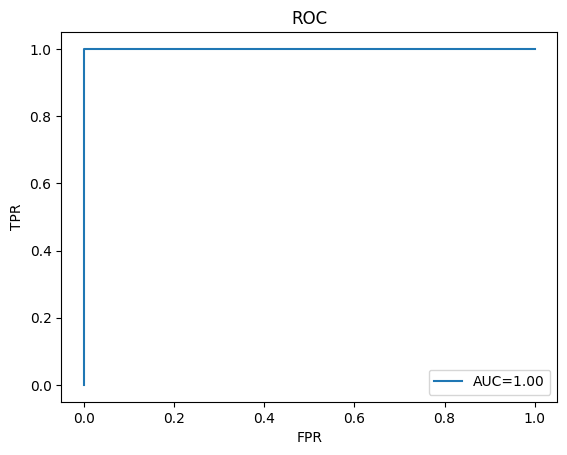

Optimal threshold from ROC: 0.968


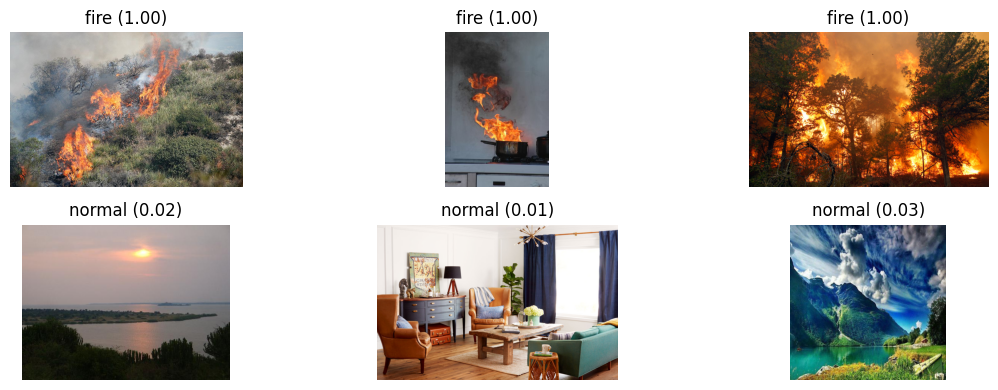

In [16]:
# ========== 2. TRANSFORMS ==========
mean, std = [0.485,0.456,0.406], [0.229,0.224,0.225]
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.3,0.3,0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# ====== 3. Datasets & Sampler ======
train_ds = datasets.ImageFolder(base_dir/"train", transform=train_transform)
val_ds   = datasets.ImageFolder(base_dir/"val",   transform=val_transform)
# Xác định index của lớp fire
fire_idx = train_ds.class_to_idx['fire']

# class counts
total_counts = {cls: sum(1 for _,y in train_ds.imgs if y==idx)
                for cls, idx in train_ds.class_to_idx.items()}
count_fire  = total_counts['fire']
count_norm  = total_counts['normal']

# Weighted sampler
weights_per_class = {idx: 1.0/count for cls, idx in train_ds.class_to_idx.items() for count in [total_counts[cls]]}
sample_weights = [weights_per_class[y] for _,y in train_ds.imgs]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_ds, batch_size=32, sampler=sampler, num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=2)

# ========== 4. MÔ HÌNH & LOSS BINARY ==========
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(device)

# pos_weight để ưu tiên lớp fire (positive)
pos_weight = torch.tensor([count_norm/count_fire], device=device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

# ========== 5. TRAIN/VAL FUNCTIONS ==========
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

def train_one_epoch():
    model.train(); total_loss = 0
    for imgs, lbls in tqdm(train_loader, desc='Train'):
        imgs = imgs.to(device)
        # mapping nhãn: fire->1, normal->0
        binary_lbls = (lbls == fire_idx).float().unsqueeze(1).to(device)
        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, binary_lbls)
        loss.backward(); optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

@torch.no_grad()
def validate_collect(thresh=0.5):
    model.eval()
    y_true, y_pred, y_score = [], [], []
    for imgs, lbls in tqdm(val_loader, desc='Val'):
        imgs = imgs.to(device)
        logits = model(imgs)
        probs  = torch.sigmoid(logits).cpu().squeeze()
        # preds=1 khi fire
        preds  = (probs > thresh).long().tolist()
        y_true.extend((lbls==fire_idx).long().tolist())
        y_pred.extend(preds)
        y_score.extend(probs.tolist())
    return y_true, y_pred, y_score

# Hàm compute metrics

def compute_metrics(y_true, y_pred, y_score):
    cm = confusion_matrix(y_true, y_pred)
    cr = classification_report(y_true, y_pred, target_names=['normal','fire'])
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    return cm, cr, fpr, tpr, thresholds, roc_auc

# ========== 6. TRAINING LOOP ==========
best_auc, no_improve = 0, 0
for epoch in range(1, 11):
    train_loss = train_one_epoch()
    y_true, y_pred, y_score = validate_collect(thresh=0.5)
    cm, cr, fpr, tpr, thresholds, roc_auc = compute_metrics(y_true, y_pred, y_score)
    scheduler.step(train_loss)
    print(f"Epoch {epoch}: TrainLoss={train_loss:.4f}, AUC={roc_auc:.4f}")
    print("CM:\n", cm)
    print(cr)
    if roc_auc > best_auc:
        best_auc = roc_auc; no_improve = 0
        torch.save(model.state_dict(), 'best_fire_model.pth')
        # chọn threshold optimal
        best_threshold = thresholds[(tpr - fpr).argmax()]
    else:
        no_improve += 1
        if no_improve >= 3:
            print("Early stopping.")
            break

# ========== 7. VẼ ROC ==========
plt.figure(); plt.plot(fpr, tpr, label=f'AUC={roc_auc:.2f}'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC'); plt.legend(); plt.show()
print(f"Optimal threshold from ROC: {best_threshold:.3f}")

# ========== 8. HÀM DỰ ĐOÁN ==========
def predict_image(path, thresh=None):
    if thresh is None: thresh = best_threshold
    img = Image.open(path).convert('RGB')
    inp = val_transform(img).unsqueeze(0).to(device)
    model.load_state_dict(torch.load('best_fire_model.pth'))
    model.eval()
    with torch.no_grad(): prob = torch.sigmoid(model(inp)).item()
    return ('fire', prob) if prob>thresh else ('normal', prob)

# ========== 9. VISUAL TEST ==========
samples = list((base_dir/"val"/"fire").glob("*"))[:3] + list((base_dir/"val"/"normal").glob("*"))[:3]
plt.figure(figsize=(12,4))
for i, p in enumerate(samples,1):
    cls, prob = predict_image(p)
    img = Image.open(p)
    plt.subplot(2,3,i); plt.imshow(img); plt.axis("off")
    plt.title(f"{cls} ({prob:.2f})")
plt.tight_layout(); plt.show()

Saving -_panoramio_(785).jpg to -_panoramio_(785).jpg
Saving Fire-Pix-1.jpg to Fire-Pix-1 (1).jpg
Saving images (1).jpg to images (1) (2).jpg
Saving images (2).jpg to images (2) (3).jpg
Saving images (3).jpg to images (3) (1).jpg
Saving sun-images.jpg to sun-images.jpg
-_panoramio_(785).jpg → normal (P_fire=0.312)


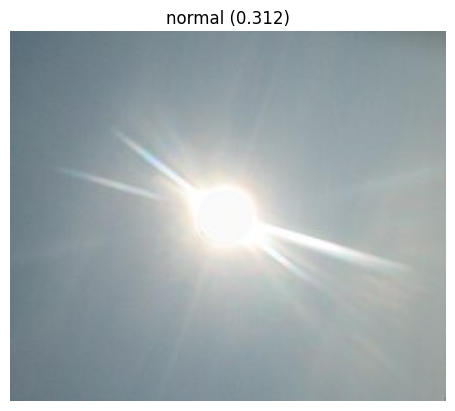

Fire-Pix-1 (1).jpg → fire (P_fire=1.000)


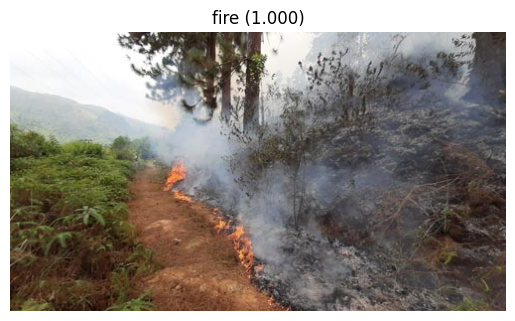

images (1) (2).jpg → fire (P_fire=0.983)


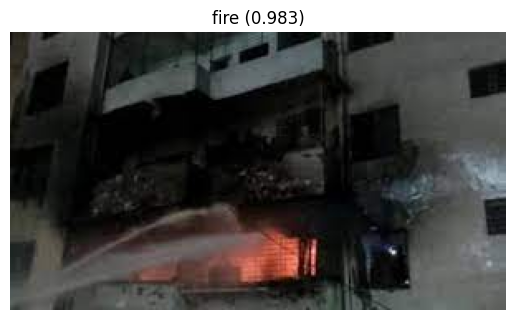

images (2) (3).jpg → fire (P_fire=1.000)


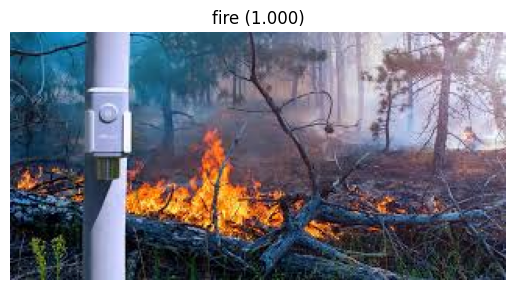

images (3) (1).jpg → fire (P_fire=0.990)


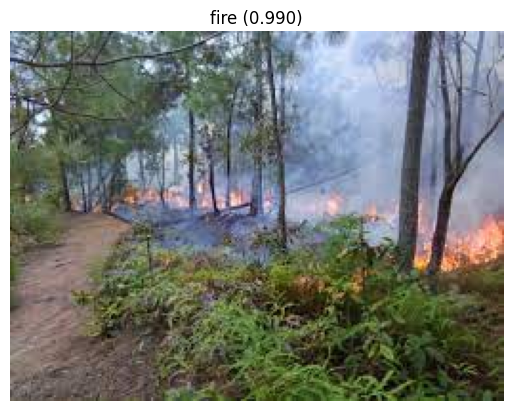

sun-images.jpg → normal (P_fire=0.948)


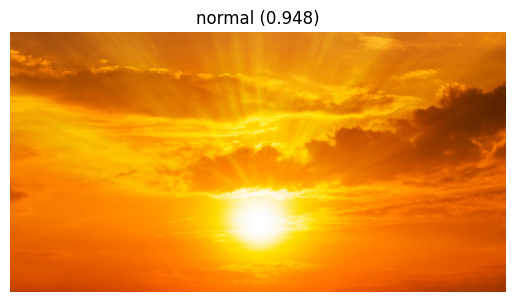

In [21]:
from google.colab import files

# 1) Upload ảnh lên
uploaded = files.upload()   # Chọn file .jpg/.png từ máy bạn

# 2) Lấy tên file vừa upload
for fname in uploaded.keys():
    img_path = fname  # ví dụ 'test_fire.jpg'

    # 3) Dự đoán
    cls, prob = predict_image(img_path)   # hàm đã định nghĩa trong code
    print(f"{fname} → {cls} (P_fire={prob:.3f})")

    # 4) Hiển thị ảnh cùng kết quả
    from PIL import Image
    import matplotlib.pyplot as plt

    img = Image.open(img_path)
    plt.imshow(img); plt.axis('off')
    plt.title(f"{cls} ({prob:.3f})")
    plt.show()


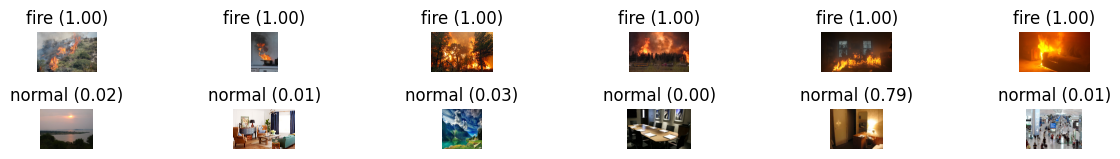

In [22]:
# ========== 9. VISUAL TEST ==========
samples = list((base_dir/"val"/"fire").glob("*"))[:6] + list((base_dir/"val"/"normal").glob("*"))[:6]
plt.figure(figsize=(12,4))
for i, p in enumerate(samples,1):
    cls, prob = predict_image(p)
    img = Image.open(p)
    plt.subplot(5,6,i); plt.imshow(img); plt.axis("off")
    plt.title(f"{cls} ({prob:.2f})")
plt.tight_layout(); plt.show()